In [1]:
import argparse
import json
from random import sample
from math import floor
from pathlib import Path
from typing import Callable

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import torch.distributed as dist
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import IterableDataset
from torchvision import transforms
from torchvision.transforms.functional import crop

from egg.core.interaction import Interaction, LoggingStrategy
from egg.core.batch import Batch
from egg.zoo.referential_language.games import build_game
from egg.zoo.referential_language.data import pil_loader

from IPython.core.debugger import set_trace

mpl.rcParams['figure.dpi']= 100

In [37]:
def loss(
    _sender_input,
    _message,
    _receiver_input,
    receiver_output,
    _labels,
    aux_input,
):
    max_objs = aux_input["mask"].shape[1]
    labels = aux_input["game_labels"].view(-1)
    acc = (receiver_output[0::max_objs].argmax(dim=-1) == labels).detach().float()
    return torch.zeros(1), {"acc": acc, "baseline": aux_input["baseline"]}

In [17]:
class TestVisualGenomeDatasetDifferentDistractors(IterableDataset):
    def __init__(
        self,
        image_dir: str,
        metadata_dir: str,
        classes_path: str = "/private/home/rdessi/EGG/egg/zoo/referential_language/utils/classes_1600.txt",
        split: str = "test",
        transform: Callable = transforms.ToTensor(),
        max_objects=9,
        image_size=64,
    ):
        assert max_objects >= 3
        path_images = Path(image_dir)
        path_metadata = Path(metadata_dir) / f"{split}_objects.json"
        path_image_data = Path(metadata_dir) / f"{split}_image_data.json"

        with open(path_image_data) as img_in, open(path_metadata) as metadata_in:
            img_data, object_data = json.load(img_in), json.load(metadata_in)
        assert len(img_data) == len(object_data)

        self.class2id = {}
        idx = 0
        with open(classes_path) as f:
            for line in f:
                names = line.strip().split(",")
                for name in names:
                    self.class2id[name] = idx
                    idx += 1

        object_dict = {}
        for object_item in object_data:
            object_dict[object_item["image_id"]] = object_item

        self.samples = []
        for img_item in img_data:
            image_id = img_item["image_id"]
            object_item = object_dict[image_id]

            img_path = path_images / "/".join(img_item["url"].split("/")[-2:])

            self.samples.append((img_path, object_item["objects"]))

        self.id2class = {v: k for k, v in self.class2id.items()}
        self.transform = transform
        self.max_objects = max_objects
        self.resizer = transforms.Resize(size=(image_size, image_size))

    def __len__(self):
        return len(self.samples)

    def _load_and_transform(self, img_path):
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image

    def _crop_and_resize_object(self, image, obj_item):
        y, x, h, w = obj_item["y"], obj_item["x"], obj_item["h"], obj_item["w"]
        return self.resizer(crop(image, y, x, h, w))

    def __iter__(self):
        self.curr_idx = 0
        self.curr_obj_idx = 0

        world_size = dist.get_world_size() if dist.is_initialized() else 1
        rank = dist.get_rank() if dist.is_initialized() else 0
        per_gpu = int(floor(len(self.samples) / float(world_size)))

        iter_start = per_gpu * rank
        iter_end = iter_start + per_gpu

        worker_info = torch.utils.data.get_worker_info()
        if worker_info:  # num_workers is > 0
            per_worker = int(floor(per_gpu / worker_info.num_workers))
            iter_start = iter_start + worker_info.id * per_worker
            iter_end = iter_start + per_worker

        self.samples = self.samples[iter_start:iter_end]
        self._load_new_sample()  # load first sample
        return self

    def _load_new_sample(self):
        img_path, obj_data = self.samples[self.curr_idx]
        self.curr_img = self._load_and_transform(img_path)
        self.curr_obj_data = obj_data
        self.max_obj_idx = min(self.max_objects, len(self.curr_obj_data))

    def __next__(self):
        if self.curr_obj_idx >= self.max_obj_idx:
            self.curr_obj_idx = 0
            self.curr_idx += 1
            if self.curr_idx >= len(self.samples):
                raise StopIteration
            self._load_new_sample()

        obj_data = self.curr_obj_data[self.curr_obj_idx]
        obj = self._crop_and_resize_object(self.curr_img, obj_data)
        self.curr_obj_idx += 1

        label = next(filter(lambda n: n in self.class2id, obj_data["names"]), None)
        assert label is not None
        label = self.class2id[label]
        sender_objs, labels, recv_objs = [obj], [torch.Tensor([label, label])], [obj]

        img_path, dist_data = sample(self.samples, k=1)[0]
        while len(dist_data) <= min(self.max_objects - 1, len(self.curr_obj_data)):
            img_path, dist_data = sample(self.samples, k=1)[0]

        sender_img = self._load_and_transform(img_path)
        max_n_dist = min(self.max_objects - 1, len(self.curr_obj_data))
        for distractor_idx in range(max_n_dist):
            if self.curr_obj_idx - 1 == distractor_idx:
                continue

            sender_bbox = dist_data[distractor_idx]
            sender_obj = self._crop_and_resize_object(sender_img, sender_bbox)

            recv_bbox = self.curr_obj_data[distractor_idx]
            recv_obj = self._crop_and_resize_object(self.curr_img, recv_bbox)
            
            label1 = next(
                filter(lambda n: n in self.class2id, sender_bbox["names"]),
                None,
            )
            label2 = next(
                filter(lambda n: n in self.class2id, recv_bbox["names"]),
                None,
            )
            assert label1 is not None and label2 is not None
            labels.append(torch.Tensor([self.class2id[label1], self.class2id[label2]]))

            sender_objs.append(sender_obj)
            recv_objs.append(recv_obj)


        sender_input = torch.stack(sender_objs)
        recv_input = torch.stack(recv_objs)
        labels = torch.stack(labels)
        return sender_input, labels, recv_input


def collate_test(batch):
    sender_input, labels, recv_input = [], [], []
    for obj_sender, label, obj_recv in batch:
        sender_input.append(obj_sender)
        labels.append(label)
        recv_input.append(obj_recv)

    sender_input = pad_sequence(sender_input, batch_first=True, padding_value=-1)
    recv_input = pad_sequence(recv_input, batch_first=True, padding_value=-1)
    labels = pad_sequence(labels, batch_first=True, padding_value=-1)
    
    mask = sender_input[:, :, 0, 0, 0] != -1
    baseline = 1 / mask.int().sum(-1)
    bsz = sender_input.shape[0]
    game_labels = torch.arange(bsz)
    aux_input = {
        "mask": mask,
        "game_labels": game_labels,
        "baseline": baseline,
    }
    return sender_input, labels, recv_input, aux_input

def get_dataloader(data_kwargs):
    ds = TestVisualGenomeDatasetDifferentDistractors(
        image_dir=data_kwargs["image_dir"],
        metadata_dir=data_kwargs["metadata_dir"],
        split=data_kwargs["split"],
        max_objects=data_kwargs["max_objects"],
        image_size=data_kwargs["image_size"],
    )
    dataloader = torch.utils.data.DataLoader(
        ds,
        batch_size=data_kwargs["batch_size"],
        num_workers=0,
        collate_fn=collate_test,
        pin_memory=True,
        drop_last=True,
    )
    return dataloader

In [18]:
data_kwargs = {
    "image_dir": "/private/home/rdessi/visual_genome",
    "metadata_dir": "/private/home/rdessi/visual_genome/filtered_splits",
    "batch_size": 32,
    "split": "test",
    "image_size": 64,
    "max_objects": 9,
    "seed": 111,
}
dl = get_dataloader(data_kwargs)

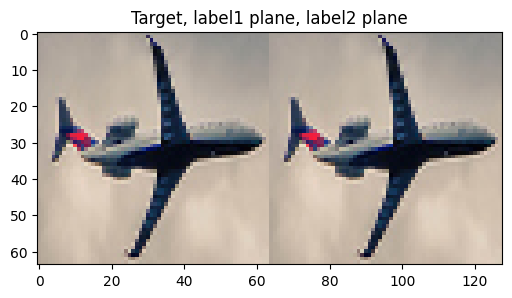

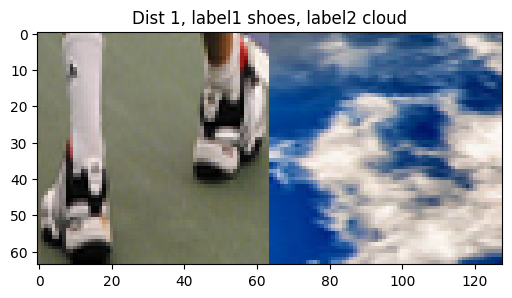

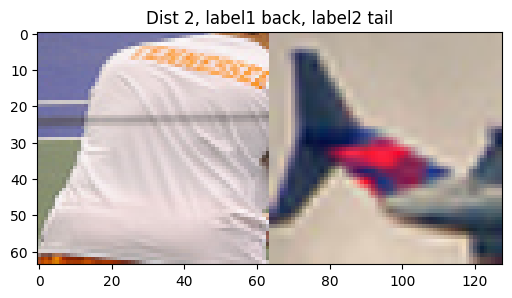

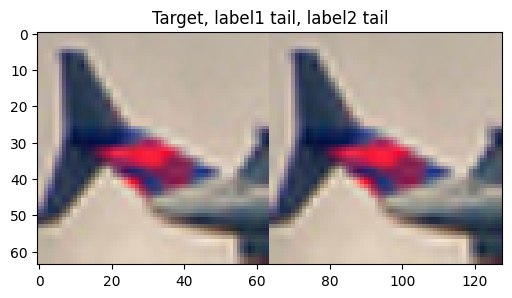

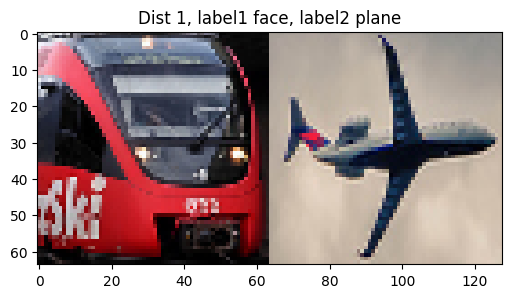

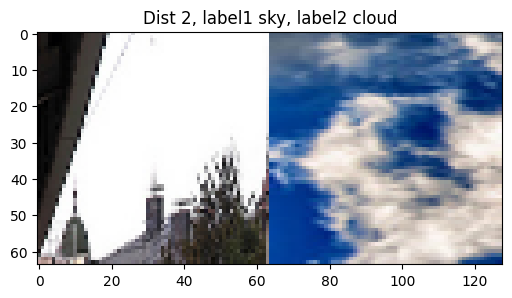

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


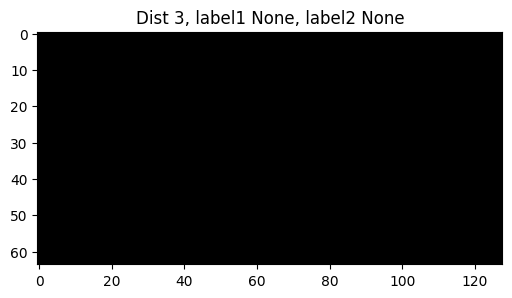

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


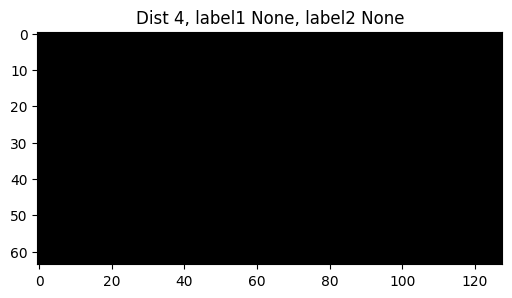

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


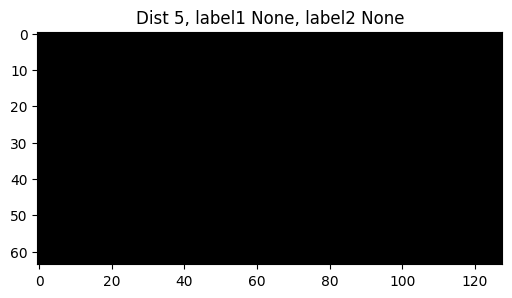

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


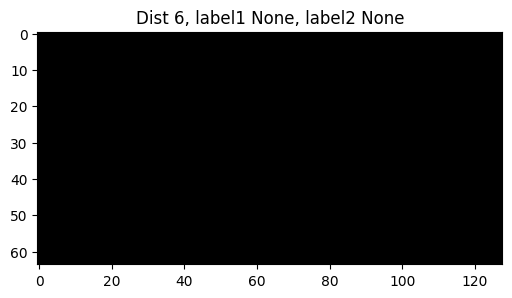

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


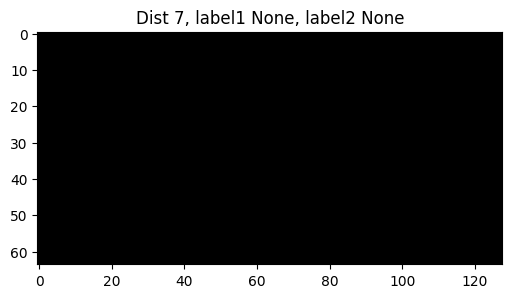

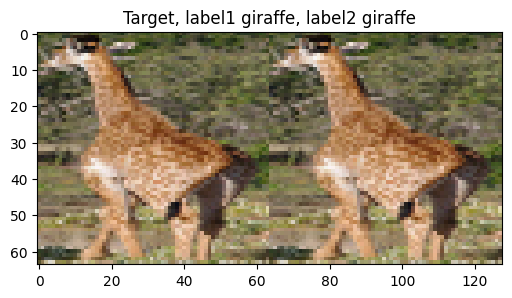

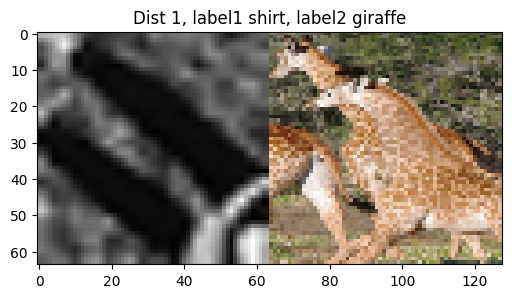

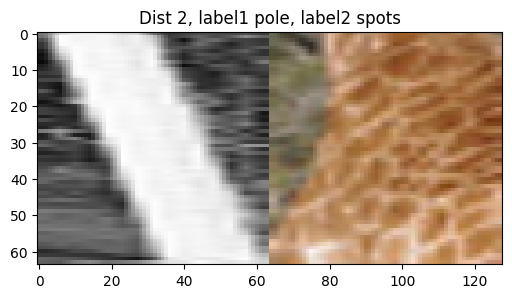

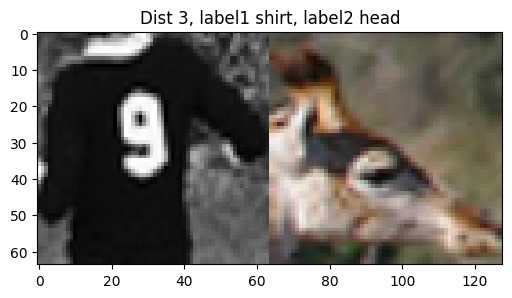

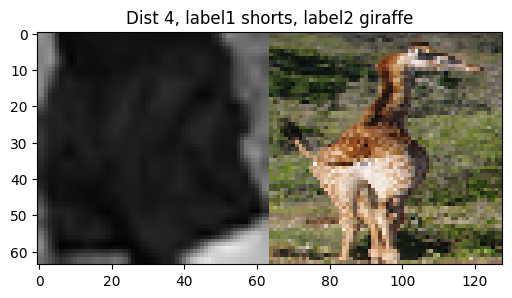

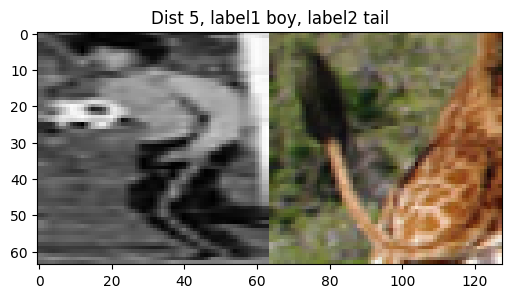

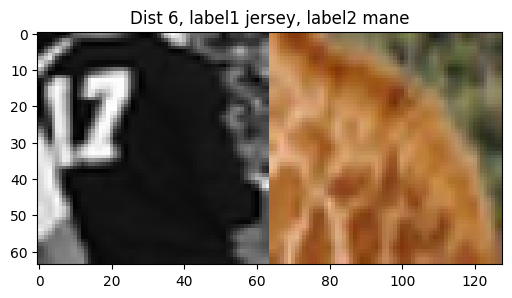

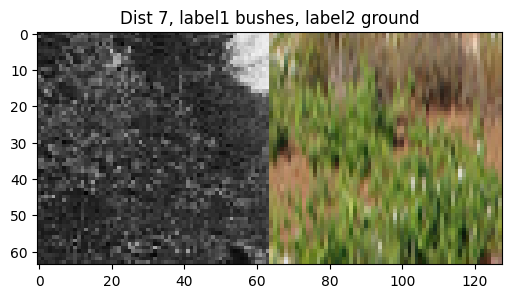

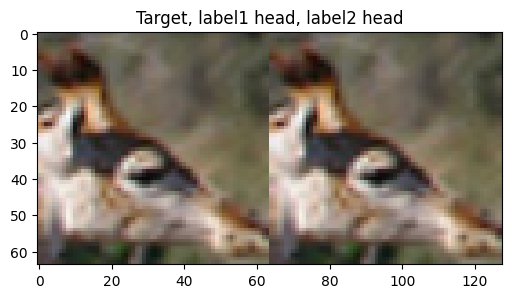

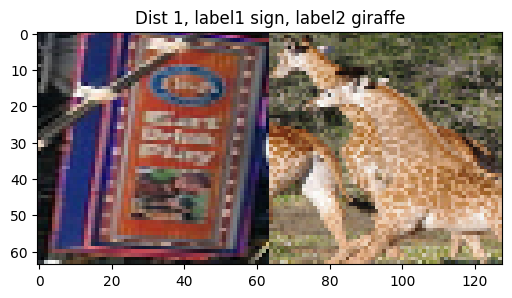

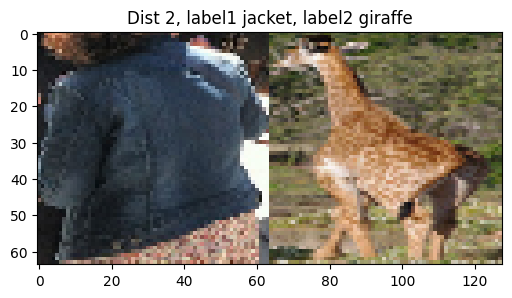

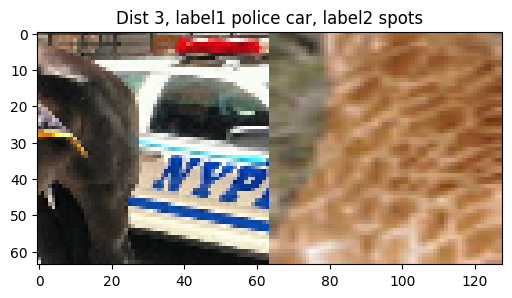

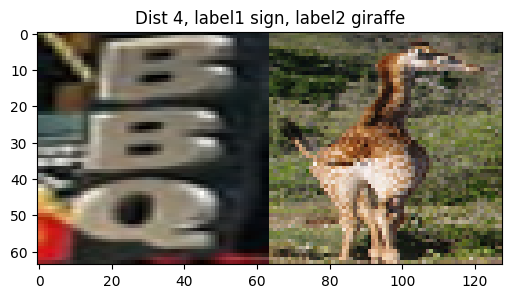

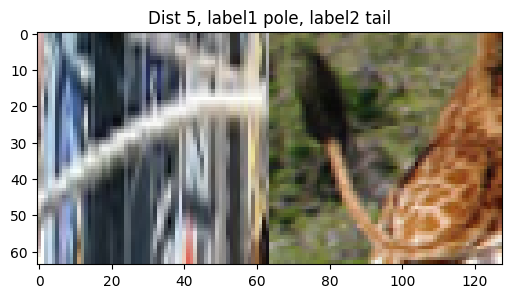

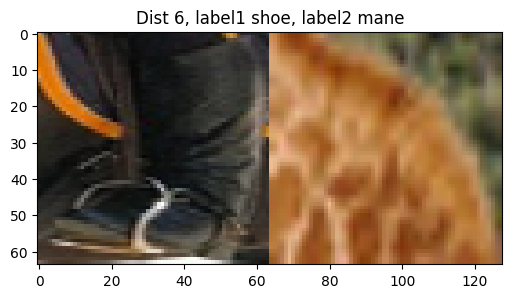

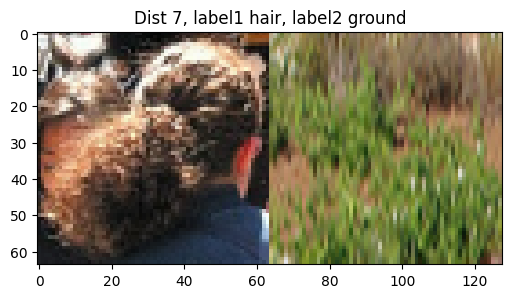

In [38]:
id2class = dl.dataset.id2class
for batch_id, batch in enumerate(dl):
    sender_input, labels, recv_input, aux_input = batch
    
    for idx in range(sender_input.shape[1]):        
        obj_sender = sender_input[0][idx].permute(1, 2, 0)
        obj_recv = recv_input[0][idx].permute(1, 2, 0)
        pair = torch.cat([obj_sender, obj_recv], dim=1)
        
        label1 = id2class.get(labels[0][idx][0].item(), "None")
        label2 = id2class.get(labels[0][idx][1].item(), "None")

        plt.title(f"{'Target' if idx == 0 else f'Dist {idx}'}, label1 {label1}, label2 {label2}")
        plt.imshow(pair.numpy())
        plt.show()


    if batch_id == 3:
        break

In [ ]:
def run_swap_test(trainer, opts, data_kwargs):

    game = trainer.game.game
    game.test_logging_strategy = test_logging_strategy
    game.loss = loss